## C1조_종합실습2(후판 공정 불량 영향 인자 분석 프로젝트)

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot, add_constant
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
warnings.filterwarnings('ignore')


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

matplotlib.rc("font", family = "NanumBarunGothic")
matplotlib.rc('axes', unicode_minus=False)

In [4]:
import warnings
import platform
warnings.filterwarnings('ignore')

## 1. 모델 불러오기

In [92]:
df_raw = pd.read_csv("SCALE불량.csv", encoding = 'euc-kr')
df_raw.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1열,1144,116,1133,59,259,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,2열,1144,122,1135,53,238,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1열,1129,116,1121,55,258,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,2열,1152,125,1127,68,266,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1열,1140,134,1128,48,246,TMCP(온도제어),873,8,1조


## 2. 통계 분석

In [93]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  rolling_method   1000 non-null   o

In [94]:
df_raw.describe()

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,26.78200,2831.900000,36788.200000,1157.245000,85.972000,1150.928000,71.720000,238.589000,934.637000,8.557000
std,18.13757,494.081478,13912.387116,21.245007,26.346297,17.344384,20.602137,38.194828,96.598015,1.604158
min,12.00000,1800.000000,7900.000000,1103.000000,55.000000,1113.000000,35.000000,165.000000,0.000000,5.000000
25%,15.00000,2500.000000,26650.000000,1140.000000,66.000000,1135.750000,57.750000,210.000000,893.750000,8.000000
50%,19.00000,2800.000000,40400.000000,1159.000000,75.000000,1156.000000,66.000000,230.000000,948.000000,9.000000
75%,34.00000,3100.000000,49100.000000,1173.000000,102.250000,1164.000000,81.000000,263.000000,991.000000,10.000000
max,100.00000,4600.000000,54900.000000,1206.000000,158.000000,1185.000000,145.000000,362.000000,1078.000000,10.000000


plate_no 는 분석에 필요하지 Plate 번호 정보 → 열 삭제

In [95]:
df = df_raw
df.drop(labels = 'plate_no', axis = 1, inplace = True)

##### spec_long의 경우 제품 규격을 나타냄 '-'로 구분뒤어 ’규격’+’강제 등급’+’열처리 방식’의 정보를 포함하고 있음

## 3. 결측치 제거

In [96]:
df.isnull().sum()

rolling_date       0
scale              0
spec_long          0
spec_country       0
steel_kind         0
pt_thick           0
pt_width           0
pt_length          0
hsb                0
fur_no             0
fur_input_row      0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
rolling_method     0
rolling_temp       0
descaling_count    0
work_group         0
dtype: int64

##### 데이터의 결측치를 확인해본 결과 결측치가 존재하지 않음

불량 발생 여부를 파악하기 위해 목표변수인 scale을 드랍함

그래프 확인 결과, rolling_temp가 0인 이상치를 확인할 수 있다

In [97]:
outliers = df[df['rolling_temp'] == 0]
outliers

,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
53,03JAN2023:16:22:29,양품,GL-E36-TM,독일,T,56,3800,11400,적용,3호기,2열,1132,95,1128,80,244,TMCP(온도제어),0,6,1조
221,04JAN2023:19:44:09,양품,JS-SM490YB,일본,C,16,2200,43600,적용,3호기,2열,1163,57,1166,67,228,CR(제어압연),0,10,2조
222,04JAN2023:19:56:39,양품,JS-SM490YB,일본,C,16,2200,43600,적용,3호기,1열,1169,64,1164,61,188,CR(제어압연),0,10,2조
598,07JAN2023:11:40:51,양품,PILAC-BT33,한국,T,81,2100,12900,적용,2호기,1열,1133,89,1122,59,229,CR(제어압연),0,6,3조
599,07JAN2023:11:52:00,양품,PILAC-BT33,한국,T,81,2100,13200,적용,1호기,2열,1130,92,1124,61,210,CR(제어압연),0,6,3조
600,07JAN2023:11:59:10,양품,NV-D32-TM,영국,T,40,2500,23600,적용,3호기,1열,1119,109,1117,76,260,TMCP(온도제어),0,6,3조


In [98]:
df["노냉시간 비율"]=(df["fur_total_time"]-df["fur_heat_time"]-df["fur_soak_time"])/df["fur_total_time"]

그래프 확인 결과, rolling_temp가 0인 이상치는 총 6개


rolling_temp 가 0인 이상치 중, [Spec_long  , spec_country, steel_kind, rolling_method]가 동일하여 완전 동일 제품으로 판단된다면 값 대체한다

In [99]:
# rolling_temp가 0인 이상치 데이터 필터링
outliers = df[df['rolling_temp'] == 0]

# rolling_temp가 0이 아닌 정상 데이터 필터링
normal_data = df[df['rolling_temp'] != 0]

# 완전 동일 제품이 존재하는 경우 찾기
matched_outliers = outliers[outliers.apply(lambda row:
    ((row["spec_long"], row["spec_country"], row["steel_kind"], row["rolling_method"])
     in normal_data.set_index(["spec_long", "spec_country", "steel_kind", "rolling_method"]).index),
    axis=1
)]

# 출력
matched_outliers

,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,노냉시간 비율
53,03JAN2023:16:22:29,양품,GL-E36-TM,독일,T,56,3800,11400,적용,3호기,...,1132,95,1128,80,244,TMCP(온도제어),0,6,1조,0.282787
221,04JAN2023:19:44:09,양품,JS-SM490YB,일본,C,16,2200,43600,적용,3호기,...,1163,57,1166,67,228,CR(제어압연),0,10,2조,0.456140
222,04JAN2023:19:56:39,양품,JS-SM490YB,일본,C,16,2200,43600,적용,3호기,...,1169,64,1164,61,188,CR(제어압연),0,10,2조,0.335106
598,07JAN2023:11:40:51,양품,PILAC-BT33,한국,T,81,2100,12900,적용,2호기,...,1133,89,1122,59,229,CR(제어압연),0,6,3조,0.353712
599,07JAN2023:11:52:00,양품,PILAC-BT33,한국,T,81,2100,13200,적용,1호기,...,1130,92,1124,61,210,CR(제어압연),0,6,3조,0.271429
600,07JAN2023:11:59:10,양품,NV-D32-TM,영국,T,40,2500,23600,적용,3호기,...,1119,109,1117,76,260,TMCP(온도제어),0,6,3조,0.288462


In [100]:
matched_normal_data = normal_data.merge(
    matched_outliers,
    on=["spec_long", "spec_country", "steel_kind", "rolling_method"],
    suffixes=('_normal', '_outlier')
)
selected_columns = matched_normal_data[["spec_long", "spec_country", "steel_kind", "rolling_method", "rolling_temp_normal"]]

# 출력
selected_columns

,spec_long,spec_country,steel_kind,rolling_method,rolling_temp_normal
0,GL-E36-TM,독일,T,TMCP(온도제어),836
1,GL-E36-TM,독일,T,TMCP(온도제어),832
2,GL-E36-TM,독일,T,TMCP(온도제어),832
3,GL-E36-TM,독일,T,TMCP(온도제어),832
4,GL-E36-TM,독일,T,TMCP(온도제어),841
...,...,...,...,...,...
253,PILAC-BT33,한국,T,CR(제어압연),876
254,PILAC-BT33,한국,T,CR(제어압연),876
255,PILAC-BT33,한국,T,CR(제어압연),876
256,PILAC-BT33,한국,T,CR(제어압연),842


rolling_temp 가 0인 이상치 중 동일 제품이 존재함을 확인할 수 있다

In [101]:
# rolling_temp가 0인 행과 0이 아닌 행 분리
outliers = df[df['rolling_temp'] == 0]
normal_data = df[df['rolling_temp'] != 0]

# 동일한 제품의 rolling_temp 평균값 계산
mean_temps = normal_data.groupby(['spec_long', 'spec_country', 'steel_kind', 'rolling_method'])['rolling_temp'].mean().reset_index()
mean_temps.rename(columns={'rolling_temp': 'mean_rolling_temp'}, inplace=True)

# 이상치 데이터와 평균값을 병합하여 rolling_temp를 대체
outliers = outliers.merge(mean_temps, on=['spec_long', 'spec_country', 'steel_kind', 'rolling_method'], how='left')
outliers['rolling_temp'] = outliers['mean_rolling_temp']  # 평균값으로 대체
outliers.drop(columns=['mean_rolling_temp'], inplace=True)  # 불필요한 컬럼 삭제

# 원본 데이터와 결합
df.update(outliers)

In [102]:
outliers = df[df['rolling_temp'] == 0]
outliers

,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,노냉시간 비율
53,03JAN2023:16:22:29,양품,GL-E36-TM,독일,T,56.0,3800.0,11400.0,적용,3호기,...,1132.0,95.0,1128.0,80.0,244.0,TMCP(온도제어),0.0,6.0,1조,0.282787
221,04JAN2023:19:44:09,양품,JS-SM490YB,일본,C,16.0,2200.0,43600.0,적용,3호기,...,1163.0,57.0,1166.0,67.0,228.0,CR(제어압연),0.0,10.0,2조,0.456140
222,04JAN2023:19:56:39,양품,JS-SM490YB,일본,C,16.0,2200.0,43600.0,적용,3호기,...,1169.0,64.0,1164.0,61.0,188.0,CR(제어압연),0.0,10.0,2조,0.335106
598,07JAN2023:11:40:51,양품,PILAC-BT33,한국,T,81.0,2100.0,12900.0,적용,2호기,...,1133.0,89.0,1122.0,59.0,229.0,CR(제어압연),0.0,6.0,3조,0.353712
599,07JAN2023:11:52:00,양품,PILAC-BT33,한국,T,81.0,2100.0,13200.0,적용,1호기,...,1130.0,92.0,1124.0,61.0,210.0,CR(제어압연),0.0,6.0,3조,0.271429
600,07JAN2023:11:59:10,양품,NV-D32-TM,영국,T,40.0,2500.0,23600.0,적용,3호기,...,1119.0,109.0,1117.0,76.0,260.0,TMCP(온도제어),0.0,6.0,3조,0.288462


In [103]:
df = df[df['rolling_temp'] != 0]

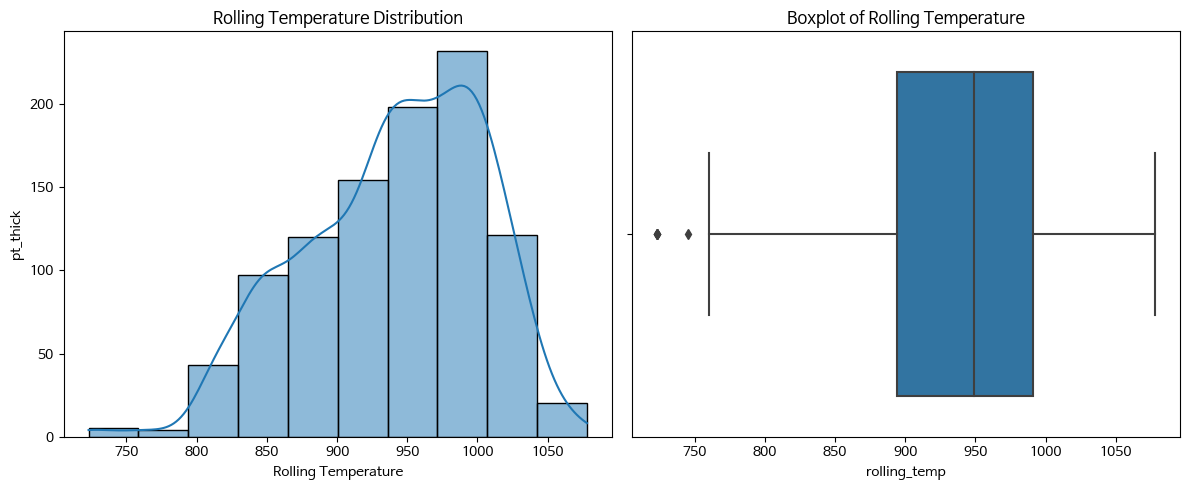

In [104]:
# 그래프 설정
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 히스토그램
sns.histplot(df["rolling_temp"], bins=10, kde=True, ax=axes[0])
axes[0].set_title("Rolling Temperature Distribution")
axes[0].set_xlabel("Rolling Temperature")
axes[0].set_ylabel("pt_thick")

# 박스플롯
sns.boxplot(x=df["rolling_temp"], ax=axes[1])
axes[1].set_title("Boxplot of Rolling Temperature")

plt.tight_layout()
plt.show()

In [105]:
df_sorted = df.sort_values(by="rolling_temp", ascending=True)
print(df_sorted)


           rolling_date scale  spec_long spec_country steel_kind  pt_thick  \
634  07JAN2023:17:24:17    양품       NV-A           영국          C      13.0   
631  07JAN2023:17:02:18    양품       BV-A          프랑스          C      13.0   
632  07JAN2023:17:10:22    양품       LR-A           영국          C      13.0   
633  07JAN2023:17:16:29    양품      NK-KA           일본          C      13.0   
549  07JAN2023:03:06:44    양품  GL-A36-TM           독일          T      40.0   
..                  ...   ...        ...          ...        ...       ...   
188  04JAN2023:14:34:33    불량   JS-SS400           일본          C      40.0   
191  04JAN2023:15:01:42    불량   JS-SS400           일본          C      80.0   
716  08JAN2023:07:04:51    불량  KS-SM400A           한국          C      40.0   
715  08JAN2023:06:57:53    불량   JS-SS400           일본          C      40.0   
187  04JAN2023:14:28:38    불량   JS-SS400           일본          C      40.0   

     pt_width  pt_length hsb fur_no  ... fur_heat_temp  fur_hea

rolling_temp 가 0인 이상치가 전부 사라짐을 확인할 수 있다

In [106]:
df

,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,노냉시간 비율
0,03JAN2023:16:22:29,양품,GL-E36-TM,독일,T,56.0,3800.0,11400.0,적용,3호기,...,1132.0,95.0,1128.0,80.0,244.0,TMCP(온도제어),842.466667,6.0,1조,0.282787
1,04JAN2023:19:44:09,양품,JS-SM490YB,일본,C,16.0,2200.0,43600.0,적용,3호기,...,1163.0,57.0,1166.0,67.0,228.0,CR(제어압연),978.926829,10.0,2조,0.456140
2,04JAN2023:19:56:39,양품,JS-SM490YB,일본,C,16.0,2200.0,43600.0,적용,3호기,...,1169.0,64.0,1164.0,61.0,188.0,CR(제어압연),978.926829,10.0,2조,0.335106
3,07JAN2023:11:40:51,양품,PILAC-BT33,한국,T,81.0,2100.0,12900.0,적용,2호기,...,1133.0,89.0,1122.0,59.0,229.0,CR(제어압연),885.605263,6.0,3조,0.353712
4,07JAN2023:11:52:00,양품,PILAC-BT33,한국,T,81.0,2100.0,13200.0,적용,1호기,...,1130.0,92.0,1124.0,61.0,210.0,CR(제어압연),885.605263,6.0,3조,0.271429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10JAN2023:05:32:25,양품,BV-A,프랑스,C,19.0,3400.0,41500.0,적용,1호기,...,1142.0,55.0,1151.0,86.0,203.0,CR(제어압연),948.000000,10.0,4조,0.305419
996,10JAN2023:05:39:19,양품,LR-A,영국,C,19.0,3400.0,41500.0,적용,1호기,...,1142.0,55.0,1151.0,86.0,209.0,CR(제어압연),948.000000,10.0,4조,0.325359
997,10JAN2023:05:52:41,양품,AB/AH32,미국,C,17.0,3400.0,43700.0,적용,2호기,...,1169.0,65.0,1163.0,77.0,227.0,CR(제어압연),948.000000,10.0,4조,0.374449
998,10JAN2023:06:01:50,양품,NV-A32,영국,C,17.0,3400.0,43700.0,적용,2호기,...,1169.0,65.0,1163.0,77.0,204.0,CR(제어압연),948.000000,10.0,4조,0.303922


In [107]:
df[['Class_Code', 'Grade', 'Treatment']] = df['spec_long'].str.split('[-/]', expand=True)

In [108]:
df.drop(columns=["Treatment"],axis=1,inplace=True)

In [109]:
df[["Class_Code","Grade"]].isnull().sum()

Class_Code     0
Grade         40
dtype: int64

In [110]:
df_filtered = df[df["Class_Code"].str.contains("H", na=False) | df["Grade"].str.contains("H", na=False)]
df_filtered

,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,...,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,노냉시간 비율,Class_Code,Grade
6,03JAN2023:08:14:02,양품,BV-EH36-TM,프랑스,T,38.0,3100.0,16700.0,적용,1호기,...,1130.0,50.0,278.0,TMCP(온도제어),878.0,8.0,1조,0.366906,BV,EH36
7,03JAN2023:08:24:12,양품,BV-EH36-TM,프랑스,T,38.0,3100.0,16700.0,적용,1호기,...,1131.0,52.0,272.0,TMCP(온도제어),870.0,8.0,1조,0.345588,BV,EH36
8,03JAN2023:08:38:23,양품,BV-EH36-TM,프랑스,T,38.0,3100.0,16700.0,적용,2호기,...,1122.0,52.0,241.0,TMCP(온도제어),873.0,8.0,1조,0.261411,BV,EH36
9,03JAN2023:08:45:58,불량,AB/EH36-TM,미국,T,38.0,3100.0,16200.0,적용,2호기,...,1124.0,73.0,290.0,TMCP(온도제어),881.0,7.0,1조,0.337931,AB,EH36
11,03JAN2023:09:02:30,양품,AB/EH36-TM,미국,T,38.0,3100.0,16200.0,적용,3호기,...,1123.0,58.0,252.0,TMCP(온도제어),869.0,8.0,1조,0.238095,AB,EH36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,10JAN2023:03:13:17,양품,LR-AH32,영국,C,12.0,3100.0,53800.0,적용,2호기,...,1159.0,61.0,227.0,CR(제어압연),919.0,10.0,4조,0.405286,LR,AH32
983,10JAN2023:03:21:21,양품,LR-AH32,영국,C,12.0,3100.0,53800.0,적용,3호기,...,1163.0,71.0,215.0,CR(제어압연),913.0,10.0,4조,0.367442,LR,AH32
986,10JAN2023:03:50:18,양품,LR-AH32,영국,C,15.0,3200.0,48200.0,적용,2호기,...,1169.0,61.0,218.0,CR(제어압연),947.0,10.0,4조,0.440367,LR,AH32
988,10JAN2023:04:09:30,양품,AB/AH32,미국,C,18.0,3300.0,40600.0,적용,1호기,...,1160.0,71.0,239.0,CR(제어압연),965.0,10.0,4조,0.426778,AB,AH32


In [111]:
df_filtered["scale"].value_counts()

양품    176
불량     45
Name: scale, dtype: int64

In [112]:
df["scale"].value_counts()

양품    684
불량    310
Name: scale, dtype: int64

In [113]:
df["온도 차이(fur_soak - rolling_temp)"] = df["fur_soak_temp"]-df["rolling_temp"]

In [114]:
df.sort_values(by="scale",inplace=True)
df.reset_index(inplace=True)

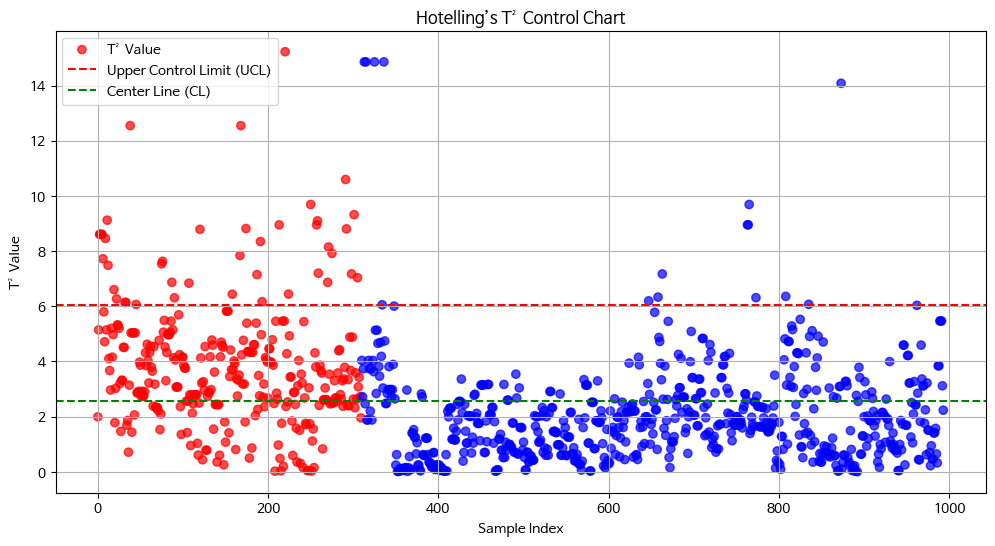

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f

# 양품(OK)과 불량(Defect) 구분
df["Status"] = df["scale"].apply(lambda x: "OK" if x == "양품" else "Defect")

# 다변량 분석을 위한 변수 선택
variables = ["온도 차이(fur_soak - rolling_temp)", "fur_heat_temp"]  # 예제 변수
df_ok = df[df["Status"] == "OK"][variables]  # 양품 데이터만 사용

# 평균 벡터와 공분산 행렬 계산
mu = df_ok.mean().values  # 평균 벡터
cov_matrix = np.cov(df_ok.T)  # 공분산 행렬
inv_cov_matrix = np.linalg.inv(cov_matrix)  # 공분산 행렬의 역행렬

# Hotelling’s T² 값 계산 함수
def calculate_t2(row):
    diff = row.values - mu
    return np.dot(np.dot(diff.T, inv_cov_matrix), diff)

df["T2"] = df[variables].apply(calculate_t2, axis=1)

# UCL (F 분포 기반 한계 계산)
p = len(variables)  # 변수 개수
n = len(df_ok)  # 양품 샘플 개수
alpha = 0.05  # 신뢰수준 95%
UCL = (p * (n + 1) * f.ppf(1 - alpha, p, n - p)) / (n - p)

# 색상 설정 (양품=파랑, 불량=빨강)
colors = df["Status"].map({"OK": "blue", "Defect": "red"})

# Hotelling’s T² 관리도 그리기
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df["T2"], c=colors, label="T² Value", alpha=0.7)
plt.axhline(UCL, color='red', linestyle='--', label="Upper Control Limit (UCL)")
plt.axhline(df["T2"].mean(), color='green', linestyle='--', label="Center Line (CL)")

# 그래프 설정
plt.title("Hotelling’s T² Control Chart")
plt.xlabel("Sample Index")
plt.ylabel("T² Value")
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()


In [116]:
# scaler = StandardScaler()
# df1=df.select_dtypes(include='number').columns
# df[df1] = scaler.fit_transform(df[df1])
# df

In [118]:
df["온도 차이(fur_heat-fur_soak)"] = df["fur_heat_temp"]-df["fur_soak_temp"]

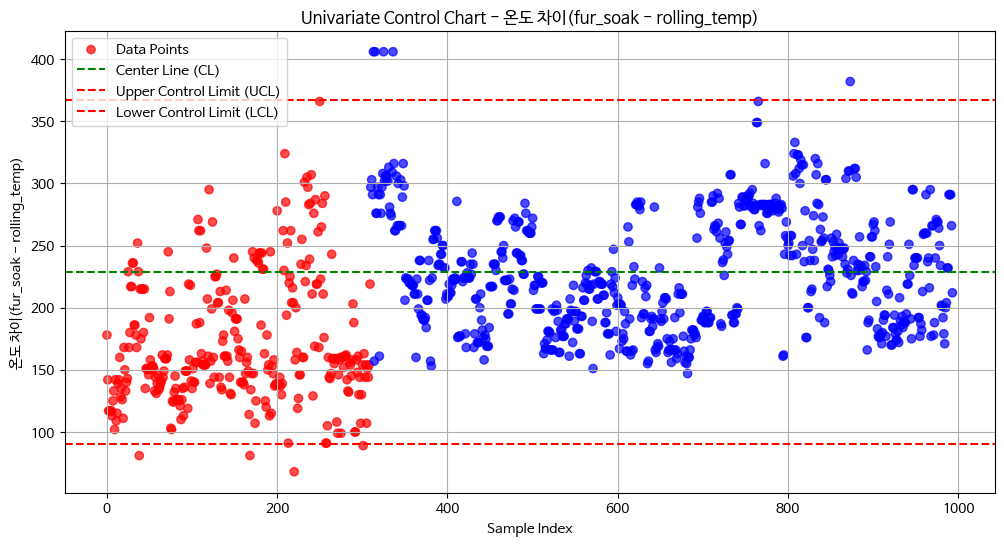

y축 값이 150 이하인 불량 개수: 131


In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 양품(OK)과 불량(Defect) 구분
df["Status"] = df["scale"].apply(lambda x: "OK" if x == "양품" else "Defect")

# 단변량 관리도를 위한 변수 선택
var = "온도 차이(fur_soak - rolling_temp)"  # 분석할 단변량 변수

# 양품(OK) 데이터의 평균 및 표준편차 계산
df_ok = df[df["Status"] == "OK"]
CL = df_ok[var].mean()  # 중심선
sigma = df_ok[var].std()  # 표준편차
UCL = CL + (3 * sigma)  # 상한 관리 한계
LCL = CL - (3 * sigma)  # 하한 관리 한계

# 색상 설정 (양품=파랑, 불량=빨강)
colors = df["Status"].map({"OK": "blue", "Defect": "red"})

# 단변량 관리도 그리기
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df[var], c=colors, label="Data Points", alpha=0.7)
plt.axhline(CL, color='green', linestyle='--', label="Center Line (CL)")
plt.axhline(UCL, color='red', linestyle='--', label="Upper Control Limit (UCL)")
plt.axhline(LCL, color='red', linestyle='--', label="Lower Control Limit (LCL)")

# 그래프 설정
plt.title(f"Univariate Control Chart - {var}")
plt.xlabel("Sample Index")
plt.ylabel(var)
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()
count_defect_under_150 = df[(df["Status"] == "Defect") & (df[var] <= 150)].shape[0]

print("y축 값이 150 이하인 불량 개수:", count_defect_under_150)

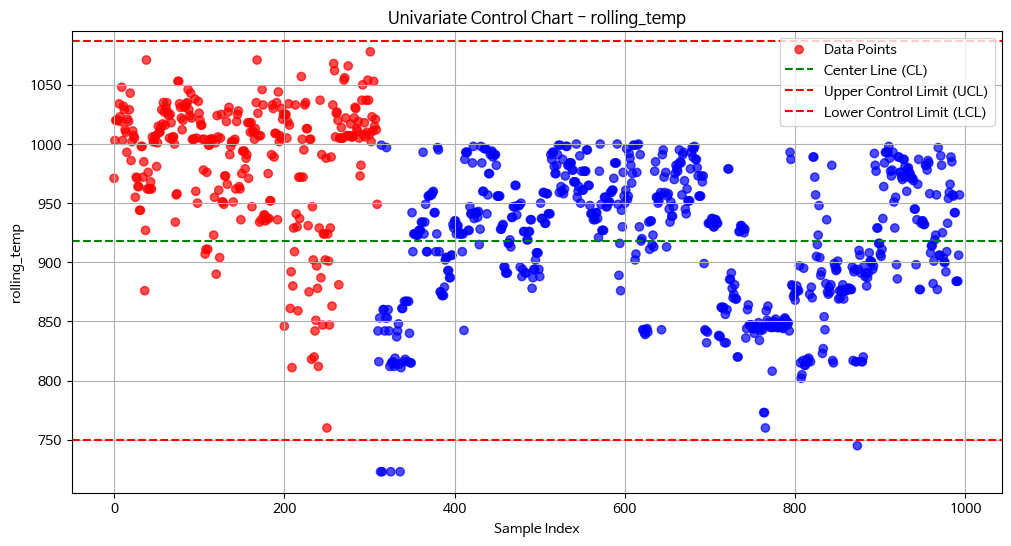

189


In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 양품(OK)과 불량(Defect) 구분
df["Status"] = df["scale"].apply(lambda x: "OK" if x == "양품" else "Defect")

# 단변량 관리도를 위한 변수 선택
var = "rolling_temp"  # 분석할 단변량 변수

# 양품(OK) 데이터의 평균 및 표준편차 계산
df_ok = df[df["Status"] == "OK"]
CL = df_ok[var].mean()  # 중심선
sigma = df_ok[var].std()  # 표준편차
UCL = CL + (3 * sigma)  # 상한 관리 한계
LCL = CL - (3 * sigma)  # 하한 관리 한계

# 색상 설정 (양품=파랑, 불량=빨강)
colors = df["Status"].map({"OK": "blue", "Defect": "red"})

# 단변량 관리도 그리기
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df[var], c=colors, label="Data Points", alpha=0.7)
plt.axhline(CL, color='green', linestyle='--', label="Center Line (CL)")
plt.axhline(UCL, color='red', linestyle='--', label="Upper Control Limit (UCL)")
plt.axhline(LCL, color='red', linestyle='--', label="Lower Control Limit (LCL)")

# 그래프 설정
plt.title(f"Univariate Control Chart - {var}")
plt.xlabel("Sample Index")
plt.ylabel(var)
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()
count_defect_under_150 = df[(df["Status"] == "Defect") & (df[var] >= 1000)].shape[0]
print(count_defect_under_150)

온도의 차이보다 rolling_temp값만 했을 때가 더 잘 분류되는 것을 알 수 있음

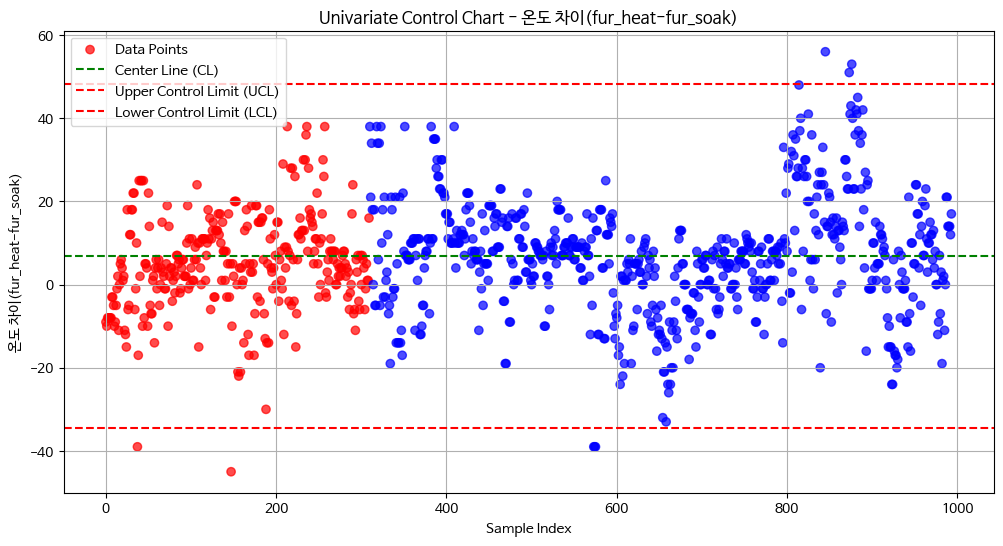

y축 값이 150 이하인 불량 개수: 310


In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 양품(OK)과 불량(Defect) 구분
df["Status"] = df["scale"].apply(lambda x: "OK" if x == "양품" else "Defect")

# 단변량 관리도를 위한 변수 선택
var = "온도 차이(fur_heat-fur_soak)"  # 분석할 단변량 변수

# 양품(OK) 데이터의 평균 및 표준편차 계산
df_ok = df[df["Status"] == "OK"]
CL = df_ok[var].mean()  # 중심선
sigma = df_ok[var].std()  # 표준편차
UCL = CL + (3 * sigma)  # 상한 관리 한계
LCL = CL - (3 * sigma)  # 하한 관리 한계

# 색상 설정 (양품=파랑, 불량=빨강)
colors = df["Status"].map({"OK": "blue", "Defect": "red"})

# 단변량 관리도 그리기
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df[var], c=colors, label="Data Points", alpha=0.7)
plt.axhline(CL, color='green', linestyle='--', label="Center Line (CL)")
plt.axhline(UCL, color='red', linestyle='--', label="Upper Control Limit (UCL)")
plt.axhline(LCL, color='red', linestyle='--', label="Lower Control Limit (LCL)")

# 그래프 설정
plt.title(f"Univariate Control Chart - {var}")
plt.xlabel("Sample Index")
plt.ylabel(var)
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()
count_defect_under_150 = df[(df["Status"] == "Defect") & (df[var] <= 150)].shape[0]

print("y축 값이 150 이하인 불량 개수:", count_defect_under_150)

In [122]:
df

,index,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,rolling_temp,descaling_count,work_group,노냉시간 비율,Class_Code,Grade,온도 차이(fur_soak - rolling_temp),Status,T2,온도 차이(fur_heat-fur_soak)
0,299,05JAN2023:08:40:39,불량,JS-SM490YB,일본,C,16.0,2500.0,37400.0,적용,...,971.0,9.0,1조,0.354369,JS,SM490YB,178.0,Defect,1.992376,-9.0
1,283,05JAN2023:05:46:30,불량,AB/A,미국,C,24.0,2600.0,42000.0,적용,...,1003.0,8.0,2조,0.287805,AB,A,142.0,Defect,5.143935,-10.0
2,282,05JAN2023:05:32:00,불량,NV-A,영국,C,25.0,2500.0,36300.0,적용,...,1020.0,8.0,2조,0.380952,NV,A,117.0,Defect,8.605741,-8.0
3,281,05JAN2023:05:21:10,불량,LR-A,영국,C,25.0,2500.0,36300.0,적용,...,1020.0,8.0,2조,0.396624,LR,A,117.0,Defect,8.605741,-8.0
4,280,05JAN2023:05:10:18,불량,JS-SS400,일본,C,25.0,2500.0,36300.0,적용,...,1020.0,8.0,2조,0.352941,JS,SS400,117.0,Defect,8.605741,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,431,06JAN2023:07:34:08,양품,GL-A,독일,C,14.0,3500.0,43000.0,적용,...,884.0,10.0,1조,0.435780,GL,A,291.0,OK,5.465721,14.0
990,432,06JAN2023:07:43:26,양품,KR-A,한국,C,14.0,3500.0,43000.0,적용,...,884.0,10.0,1조,0.440909,KR,A,291.0,OK,5.465721,14.0
991,433,06JAN2023:07:56:21,양품,LR-A,영국,C,14.0,3500.0,43000.0,적용,...,884.0,10.0,1조,0.427907,LR,A,291.0,OK,5.465721,14.0
992,435,06JAN2023:08:11:21,양품,KR-A,한국,C,12.0,3400.0,43100.0,적용,...,906.0,10.0,1조,0.342342,KR,A,266.0,OK,3.118336,12.0


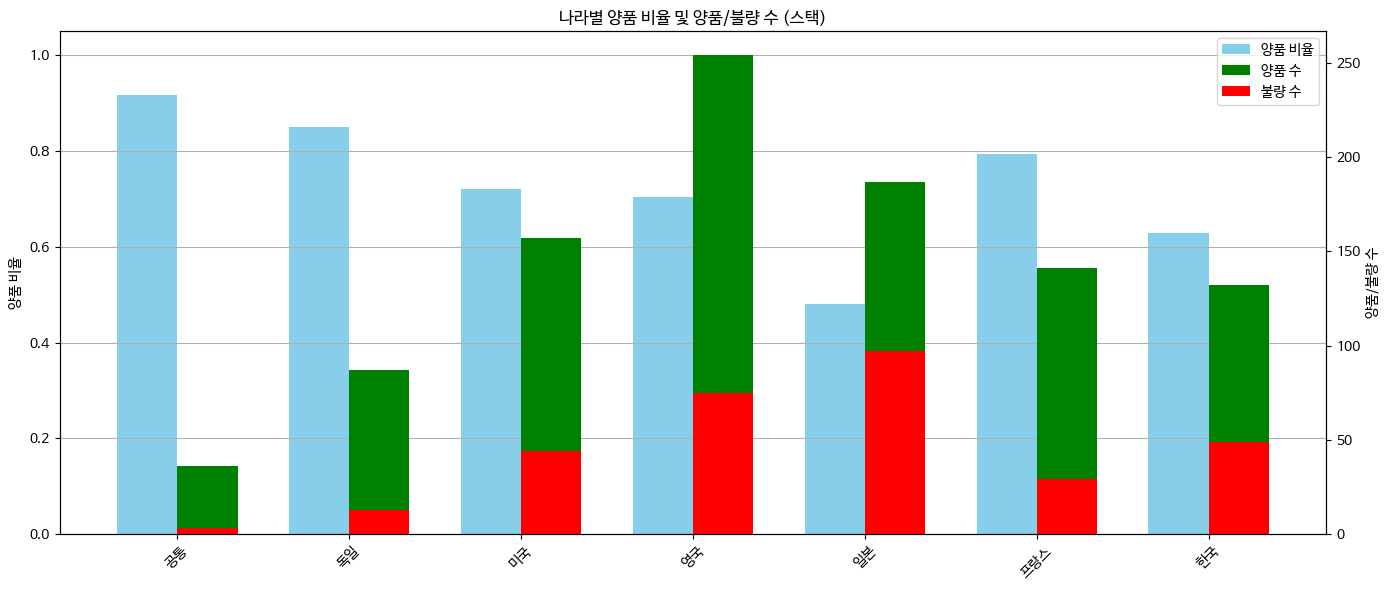

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 나라별 전체 수, 양품 수, 불량 수 계산
country_total = df.groupby("spec_country").size()
country_ok = df[df["Status"] == "OK"].groupby("spec_country").size()
country_defect = df[df["Status"] == "Defect"].groupby("spec_country").size()

# 비율 계산
ok_ratio = (country_ok / country_total).fillna(0)

# 양품/불량 수 NaN 보정
country_ok = country_ok.reindex(country_total.index, fill_value=0)
country_defect = country_defect.reindex(country_total.index, fill_value=0)

# x축 위치 설정
countries = country_total.index
x = np.arange(len(countries))
width = 0.35  # 막대 너비

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(14, 6))

# 1️⃣ 왼쪽 Y축: 비율 막대그래프
ax1.bar(x - width/2, ok_ratio, width=width, color='skyblue', label='양품 비율')
ax1.set_ylabel("양품 비율")
ax1.set_ylim(0, 1.05)

# 2️⃣ 오른쪽 Y축: 양품/불량 수 스택형 막대그래프
ax2 = ax1.twinx()
ax2.bar(x + width/2, country_ok, width=width, label='양품 수', color='green', bottom=country_defect)
ax2.bar(x + width/2, country_defect, width=width, label='불량 수', color='red')
ax2.set_ylabel("양품/불량 수")

# x축 설정
ax1.set_xticks(x)
ax1.set_xticklabels(countries, rotation=45)

# 제목 및 범례
plt.title("나라별 양품 비율 및 양품/불량 수 (스택)")
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# 그리드 및 출력
ax1.grid(axis='y')
plt.tight_layout()
plt.show()


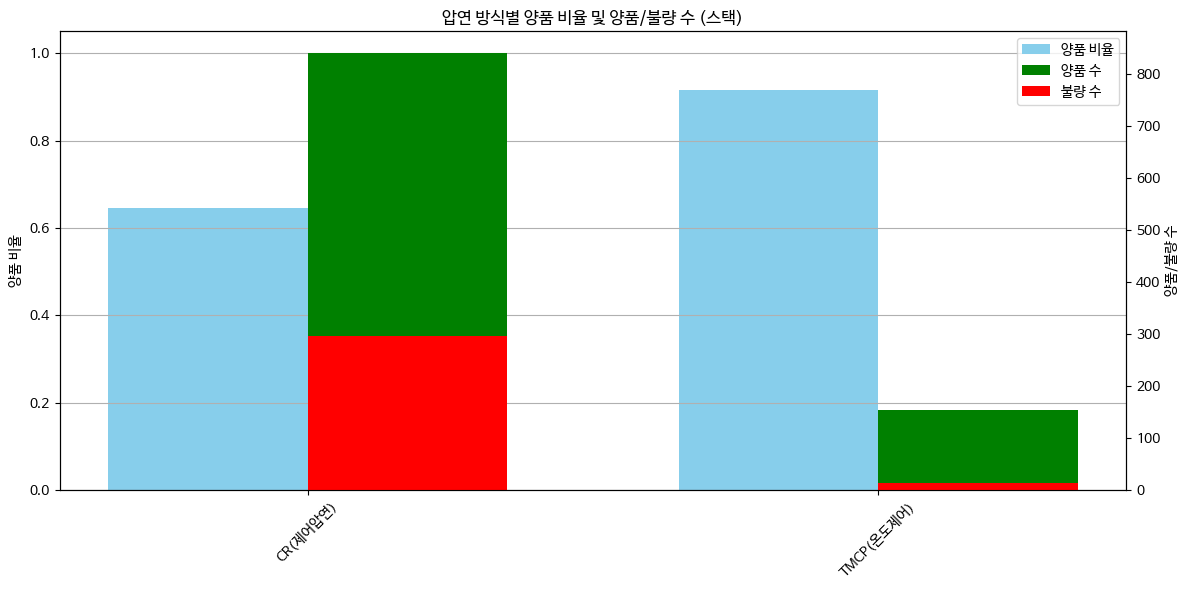

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 압연 방식별 전체 수, 양품 수, 불량 수 계산
method_total = df.groupby("rolling_method").size()
method_ok = df[df["Status"] == "OK"].groupby("rolling_method").size()
method_defect = df[df["Status"] == "Defect"].groupby("rolling_method").size()

# 비율 계산
ok_ratio = (method_ok / method_total).fillna(0)

# NaN 보정
method_ok = method_ok.reindex(method_total.index, fill_value=0)
method_defect = method_defect.reindex(method_total.index, fill_value=0)

# x축 위치 설정
methods = method_total.index
x = np.arange(len(methods))
width = 0.35

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(12, 6))

# 1️⃣ 양품 비율 (왼쪽 Y축)
ax1.bar(x - width/2, ok_ratio, width=width, color='skyblue', label='양품 비율')
ax1.set_ylabel("양품 비율")
ax1.set_ylim(0, 1.05)

# 2️⃣ 양품/불량 수 (오른쪽 Y축 스택형 막대)
ax2 = ax1.twinx()
ax2.bar(x + width/2, method_ok, width=width, label='양품 수', color='green', bottom=method_defect)
ax2.bar(x + width/2, method_defect, width=width, label='불량 수', color='red')
ax2.set_ylabel("양품/불량 수")

# x축 설정
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45)

# 제목 및 범례
plt.title("압연 방식별 양품 비율 및 양품/불량 수 (스택)")
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# 그리드 및 출력
ax1.grid(axis='y')
plt.tight_layout()
plt.show()


구분	TMCP (Thermo-Mechanical Controlled Process)	CR (Conventional Reheating-Rolling)
방식	열처리와 압연을 동시에 제어하는 정밀 공정	재가열 후 단순 압연
제어 수준	온도, 압력, 속도 등 정밀 제어 가능	상대적으로 단순하고 기계적 반복
품질 안정성	조직 미세화 → 균일한 강도와 연성 확보	품질 편차 크고, 열처리 균일성 부족
불량 원인	공정이 정밀해 불량 가능성 낮음	재가열 불균형 등으로 불량률 높음

➡ TMCP는 물리적 열처리와 압연이 정밀하게 제어되기 때문에, 제품 특성의 균일성과 공정 안정성이 높습니다.
반면, CR은 공정 조건의 편차가 클 경우 불량률 증가 가능성이 큽니다.

##### 제어압연(CR) 대한 불량을 예측해야 전체적인 결과가 좋게 나올 것이라고 판단함

In [133]:
df_CR=df[df["rolling_method"]=="CR(제어압연)"]

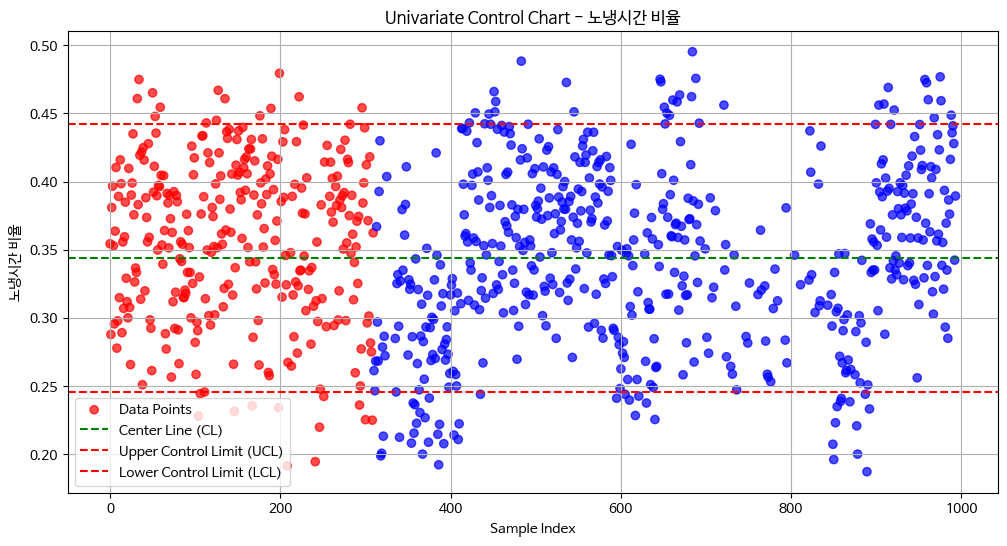

y축 값이 150 이하인 불량 개수: 297


In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 양품(OK)과 불량(Defect) 구분
df_CR["Status"] = df_CR["scale"].apply(lambda x: "OK" if x == "양품" else "Defect")

# 단변량 관리도를 위한 변수 선택
var = "노냉시간 비율"  # 분석할 단변량 변수

# 양품(OK) 데이터의 평균 및 표준편차 계산
df_ok = df_CR[df_CR["Status"] == "OK"]
CL = df_ok[var].mean()  # 중심선
sigma = df_ok[var].std()  # 표준편차
UCL = CL + (1.5 * sigma)  # 상한 관리 한계
LCL = CL - (1.5 * sigma)  # 하한 관리 한계

# 색상 설정 (양품=파랑, 불량=빨강)
colors = df_CR["Status"].map({"OK": "blue", "Defect": "red"})

# 단변량 관리도 그리기
plt.figure(figsize=(12, 6))
plt.scatter(df_CR.index, df_CR[var], c=colors, label="Data Points", alpha=0.7)
plt.axhline(CL, color='green', linestyle='--', label="Center Line (CL)")
plt.axhline(UCL, color='red', linestyle='--', label="Upper Control Limit (UCL)")
plt.axhline(LCL, color='red', linestyle='--', label="Lower Control Limit (LCL)")

# 그래프 설정
plt.title(f"Univariate Control Chart - {var}")
plt.xlabel("Sample Index")
plt.ylabel(var)
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()
count_defect_under_150 = df_CR[(df_CR["Status"] == "Defect") & (df_CR[var] <= 150)].shape[0]

print("y축 값이 150 이하인 불량 개수:", count_defect_under_150)

In [149]:
df.select_dtypes(include='number')

,index,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,노냉시간 비율,온도 차이(fur_soak - rolling_temp),T2,온도 차이(fur_heat-fur_soak)
0,299,16.0,2500.0,37400.0,1140.0,83.0,1149.0,50.0,206.0,971.0,9.0,0.354369,178.0,1.992376,-9.0
1,283,24.0,2600.0,42000.0,1135.0,96.0,1145.0,50.0,205.0,1003.0,8.0,0.287805,142.0,5.143935,-10.0
2,282,25.0,2500.0,36300.0,1129.0,97.0,1137.0,46.0,231.0,1020.0,8.0,0.380952,117.0,8.605741,-8.0
3,281,25.0,2500.0,36300.0,1129.0,97.0,1137.0,46.0,237.0,1020.0,8.0,0.396624,117.0,8.605741,-8.0
4,280,25.0,2500.0,36300.0,1129.0,97.0,1137.0,46.0,221.0,1020.0,8.0,0.352941,117.0,8.605741,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,431,14.0,3500.0,43000.0,1189.0,63.0,1175.0,60.0,218.0,884.0,10.0,0.435780,291.0,5.465721,14.0
990,432,14.0,3500.0,43000.0,1189.0,63.0,1175.0,60.0,220.0,884.0,10.0,0.440909,291.0,5.465721,14.0
991,433,14.0,3500.0,43000.0,1189.0,63.0,1175.0,60.0,215.0,884.0,10.0,0.427907,291.0,5.465721,14.0
992,435,12.0,3400.0,43100.0,1184.0,76.0,1172.0,70.0,222.0,906.0,10.0,0.342342,266.0,3.118336,12.0


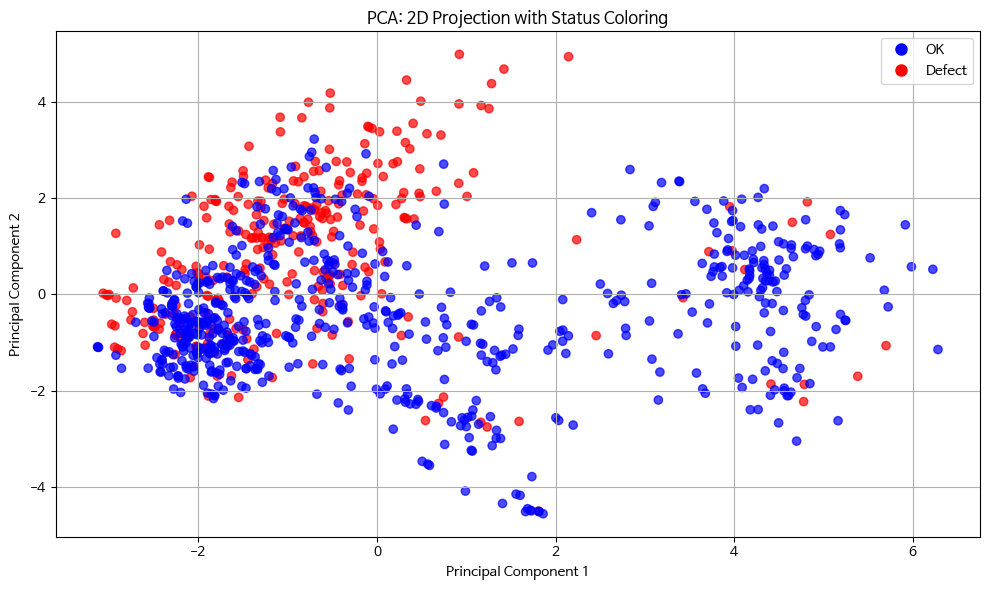

In [148]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# 🔹 사용할 변수 선택 (수치형 변수만)
variables = ["pt_thick", "pt_width", "pt_length", "fur_heat_temp", "fur_heat_time", "fur_soak_temp", "fur_soak_time","rolling_temp"]

# 🔹 결측치 제거 (또는 필요시 대체 처리)
df_clean = df.dropna(subset=variables)

# 🔹 데이터 정규화 (평균 0, 표준편차 1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clean[variables])

# 🔹 PCA 수행 (2개 주성분)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# 🔹 결과 데이터프레임에 주성분 추가
df_clean["PC1"] = pca_result[:, 0]
df_clean["PC2"] = pca_result[:, 1]

# 🔹 시각화 (양품/불량 색상 구분)
colors = df_clean["Status"].map({"OK": "blue", "Defect": "red"})

plt.figure(figsize=(10, 6))
plt.scatter(df_clean["PC1"], df_clean["PC2"], c=colors, alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: 2D Projection with Status Coloring")
plt.grid(True)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='OK', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Defect', markerfacecolor='red', markersize=10)
])
plt.tight_layout()
plt.show()


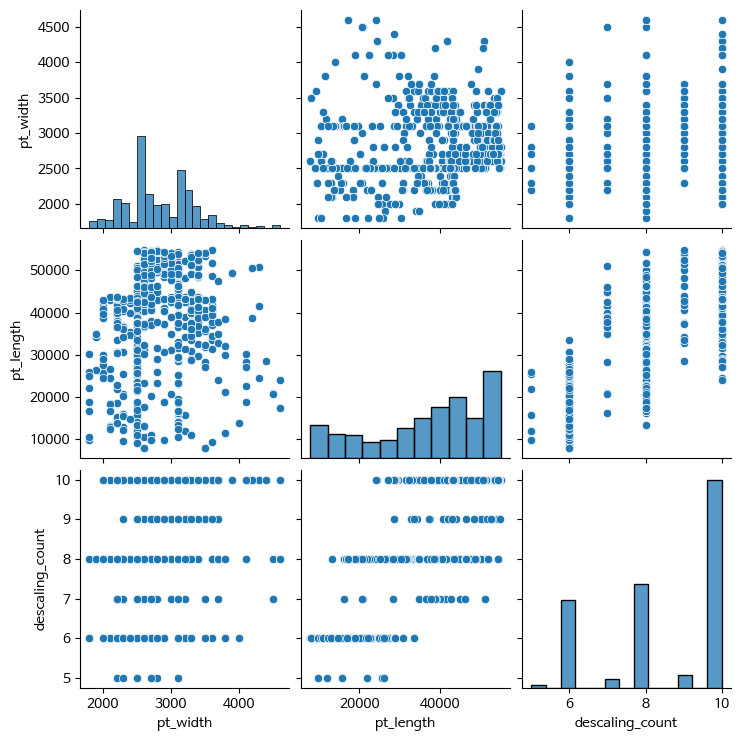

In [152]:
sns.pairplot(df[["pt_width", "pt_length","descaling_count"]])